In [1]:
# autoreload nangs
%reload_ext autoreload
%autoreload 2
%matplotlib inline


Bad key "text.kerning_factor" on line 4 in
C:\Users\sensio\miniconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


## Smith-Hutton Problem

We want to solve the following PDE:

\begin{equation}
    u \frac{\partial \phi}{\partial x} + v \frac{\partial \phi}{\partial y} = 0
\end{equation}

The independen variables (i.e, $x$, $y$) are used as input values for the NN, and the solution (i.e. $\phi(x,y)$) is the output. In order to find the solution, at each step the NN outputs are derived w.r.t the inputs. Then, a loss function that matches the PDE is built and the weights are updated accordingly. If the loss function goes to zero, we can assume that our NN is indeed the solution to our PDE. We will try to find a general solution for different values of $u$, so it will be set also as an input. The geometry of the problem is as follows:

![sh](pics/sh.png)

In [2]:
#imports

import numpy as np 
import matplotlib.pyplot as plt 
import torch
import nangs

device = "cuda" if torch.cuda.is_available() else "cpu"

nangs.__version__, torch.__version__

('0.1.1', '1.5.0')

In [3]:
from nangs import PDE

# velocity field
vel = lambda x, y: (2*y*(1-x**2), -2*x*(1-y**2))

class SH(PDE):
    def computePDELoss(self, inputs, outputs):
                
        # compute gradients
        grads = self.computeGrads(outputs, inputs)
        
        # compute loss
        dpdx, dpdy = grads[:, 0], grads[:, 1]
        x, y = inputs[:, 0], inputs[:, 1]
        u, v = vel(x, y)
        return {'pde': u*dpdx + v*dpdy}


# instanciate pde
pde = SH(inputs=('x', 'y'), outputs='p')

In [4]:
# define the mesh

from nangs import Mesh

x = np.linspace(-1,1,80)
y = np.linspace(0,1,40)

mesh = Mesh({'x': x, 'y': y}, device=device)
pde.set_mesh(mesh)

In [5]:
# boundary conditions

from nangs import Dirichlet

ALPHA = 10

# left and rigth b.c 

x1 = np.array([-1, 1])
p = np.full(2*len(y), 1. - np.tanh(ALPHA))
boco = Dirichlet({'x': x1, 'y': y}, {'p': p}, name='left_rigth', device=device)
pde.add_boco(boco)

In [6]:
# top b.c 

p = np.full(len(x), 1. - np.tanh(ALPHA))
boco = Dirichlet({'x': x, 'y': y[-1:]}, {'p': p}, device=device, name='top')
pde.add_boco(boco)

In [7]:
# bottom b.c

x1, x2 = x[x<0], x[x>=0]
p1 = 1. + np.tanh(ALPHA*(2*x1+1))

# bottom left b.c

boco = Dirichlet({'x': x1, 'y': y[:1]}, {'p': p1}, name='bottom_left', device=device)
pde.add_boco(boco)

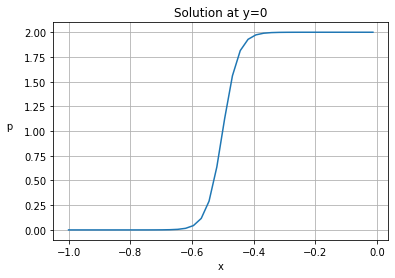

In [8]:
plt.plot(x1,p1)
plt.xlabel('x')
plt.ylabel('p      ', rotation=np.pi/2)
plt.title('Solution at y=0')
plt.grid()
plt.show()

In [9]:
# bottom right b.c

from nangs import Neumann

class MyNeumann(Neumann):
    def computeBocoLoss(self, inputs, outputs):
        dpdy = self.computeGrads(outputs, inputs)[:, 1]
        return {'gradY': dpdy}

boco = MyNeumann({'x': x2, 'y': y[:1]}, name='bottom_right', device=device)
pde.add_boco(boco)

In [10]:
from nangs import MLP

BATCH_SIZE = 1024
LR = 5e-3
EPOCHS = 100
NUM_LAYERS = 5
NUM_HIDDEN = 256

mlp = MLP(len(pde.inputs), len(pde.outputs), NUM_LAYERS, NUM_HIDDEN).to(device)
optimizer = torch.optim.Adam(mlp.parameters())
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=LR, pct_start=0.1, total_steps=EPOCHS)

pde.compile(mlp, optimizer, scheduler)
hist = pde.solve(EPOCHS, BATCH_SIZE)

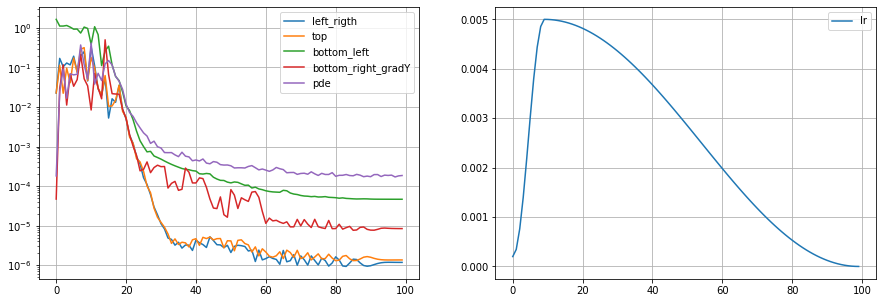

In [11]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
for name, vale in hist.items():
    if name is not 'lr':
        ax1.plot(hist[name], label=name)
ax1.grid(True)
ax1.legend()
ax1.set_yscale("log")
ax2.plot(hist['lr'], label='lr')
ax2.grid(True)
ax2.legend()
plt.show()

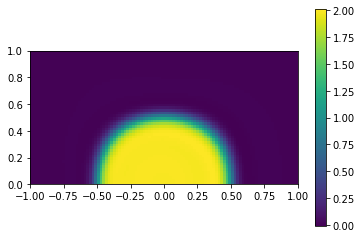

In [12]:
# evaluate the solution

x = np.linspace(-1,1,100)
y = np.linspace(0,1,50)
eval_mesh = Mesh({'x': x, 'y': y}, device=device)

p = pde.eval(eval_mesh).cpu().numpy()

plt.imshow(p.reshape((len(y),len(x))), vmin=p.min(), vmax=p.max(), origin='lower',
           extent=[x.min(), x.max(), y.min(), y.max()])
plt.colorbar()
plt.show()

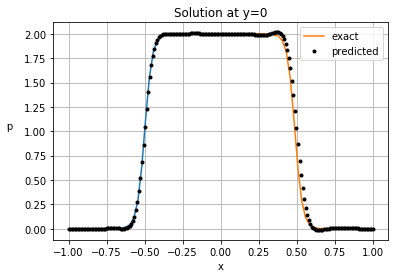

In [13]:
x = np.linspace(-1,1,200)
y = np.array([0])
eval_mesh = Mesh({'x': x, 'y': y}, device=device)
p = pde.eval(eval_mesh).cpu().numpy()

plt.plot(x1,p1)
plt.plot(x1+1,np.flip(p1), label="exact")
plt.plot(x, p, '.k', label="predicted")
plt.legend()
plt.xlabel('x')
plt.ylabel('p      ', rotation=np.pi/2)
plt.title('Solution at y=0')
plt.grid()
plt.show()